In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd gdrive/MyDrive/Project/3D_UNet_menisc_seg/scripts/

/content/gdrive/MyDrive/Project/3D_UNet_menisc_seg/scripts


In [3]:
!pip install monai segment_anything

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.7 MB/s eta 0:00:00


In [4]:
# Calculate the hausdorff distance between the ground truth and predicted masks for each test image
import numpy as np
from monai.metrics import compute_hausdorff_distance
import os
import glob
import sys
sys.path.append('../src')
from utils import crop_im

In [5]:
# Define data path
DATA_DIR = '../data'

# Get the paths
test_paths = np.array([os.path.basename(i).split('.')[0] for i in glob.glob(f'{DATA_DIR}/test/*.im')])

In [6]:
import matplotlib.pyplot as plt


In [7]:
# For a given model's predictions
# For each test path, load both predicted mask and ground truth
# compute hausdorff distance, providing the spacing
# append to list

def get_hausdorff_dists(sub_dir):

    hausdorffs = []

    for path in test_paths:
        # read in ground truth
        seg_path = os.path.join(DATA_DIR, 'ground-truth', path + '.npy')
        mask = np.load(seg_path)

        # Get menisc masks from this

        mask = mask[...,-1]
        gt = crop_im(mask)

        # Get prediction
        pred_path = os.path.join(DATA_DIR, sub_dir, path + '.npy')
        pred = np.load(pred_path)

        # add batch, channels
        gt = np.expand_dims(gt, axis=(0,1))
        pred = np.expand_dims(pred, axis=(0, 1))

        h = compute_hausdorff_distance(pred,gt,spacing=(0.365,0.456,0.7), percentile=95)

        print(h.item())

        hausdorffs.append(h.item())

    return hausdorffs

In [14]:
froz_hausdorffs = np.array(get_hausdorff_dists('frozen_enc_test_preds'))

5.490926265716553
5.238694667816162
3.328291416168213
4.065061092376709
3.4464313983917236
5.2753071784973145
2.0999999046325684
2.1489384174346924
5.863925933837891
4.234516620635986
3.5
5.0208587646484375
2.799999952316284
3.5189807415008545
2.8236899375915527
3.2881741523742676
4.921927452087402
6.942820072174072
2.6243903636932373
2.7493317127227783
3.2285892963409424
3.0999186038970947
6.596927642822266
3.4855220317840576
11.186339378356934
4.884383201599121
2.673499822616577
3.2382712364196777


In [15]:
froz_hausdorffs

array([ 5.49092627,  5.23869467,  3.32829142,  4.06506109,  3.4464314 ,
        5.27530718,  2.0999999 ,  2.14893842,  5.86392593,  4.23451662,
        3.5       ,  5.02085876,  2.79999995,  3.51898074,  2.82368994,
        3.28817415,  4.92192745,  6.94282007,  2.62439036,  2.74933171,
        3.2285893 ,  3.0999186 ,  6.59692764,  3.48552203, 11.18633938,
        4.8843832 ,  2.67349982,  3.23827124])

In [16]:
np.save("frozen_hausdorffs",froz_hausdorffs)

In [17]:
# load them up and violin plot them
froz_haus = np.load("frozen_hausdorffs.npy")
e2e_haus = np.load("end2end_hausdorffs.npy")
unet_haus = np.load("unet_hausdorffs.npy")

In [18]:
import pandas as pd

# Make dataframe of these?
haus_dict = {
    "SAM 1": froz_haus,
    "SAM 2": e2e_haus,
    "U-Net": unet_haus
}
haus_df = pd.DataFrame(haus_dict)

In [19]:
haus_df

,SAM 1,SAM 2,U-Net
0,5.490926,1.643422,1.400000
1,5.238695,1.206221,0.911680
2,3.328291,2.100000,3.068746
3,4.065061,2.599250,1.824000
4,3.446431,2.748794,1.149671
5,5.275307,1.516958,2.385037
6,2.100000,1.400000,1.400000
7,2.148938,0.860718,1.109430
8,5.863926,5.079184,2.754604
9,4.234517,5.385390,2.385037


In [20]:
haus_df.describe()

,SAM 1,SAM 2,U-Net
count,28.000000,28.000000,28.000000
mean,4.206276,2.508923,1.889956
std,1.890715,1.455040,0.681176
min,2.100000,0.860718,0.911680
25%,3.030861,1.418788,1.400000
50%,3.492761,1.885426,1.767127
75%,5.075318,2.836333,2.385037
max,11.186339,5.744585,3.500000


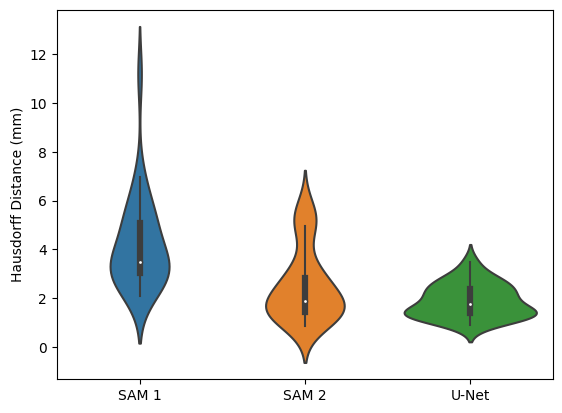

In [25]:
# Try violin plot
import matplotlib.pyplot as plt
import seaborn as sns
f, ax = plt.subplots(1)
ax = sns.violinplot(data=haus_df)
plt.ylabel("Hausdorff Distance (mm)")
plt.savefig("hausdorff_violin", bbox_inches="tight", dpi=500)
plt.show()

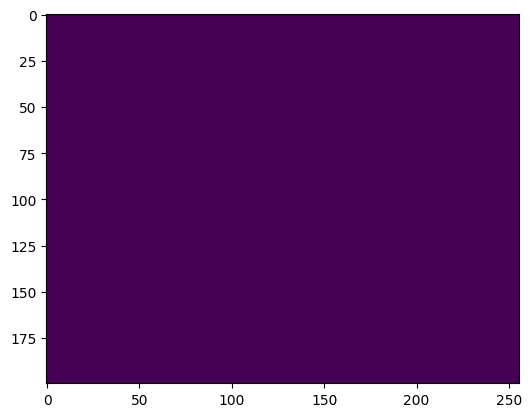

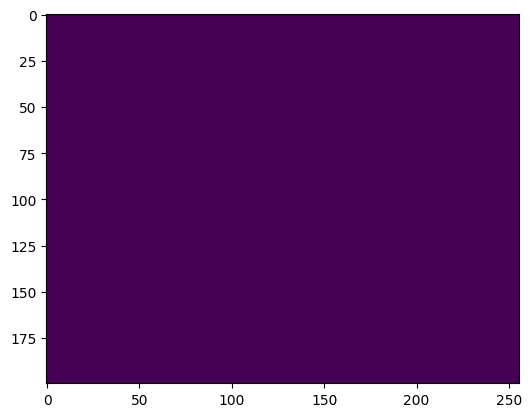

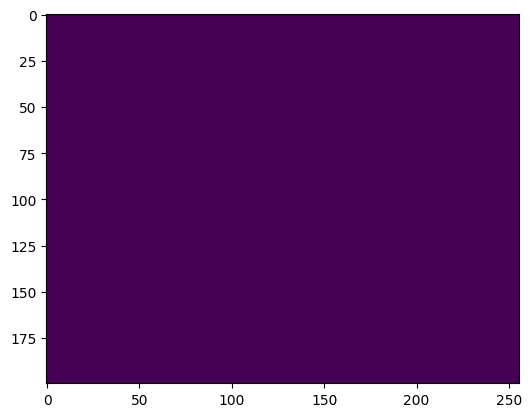

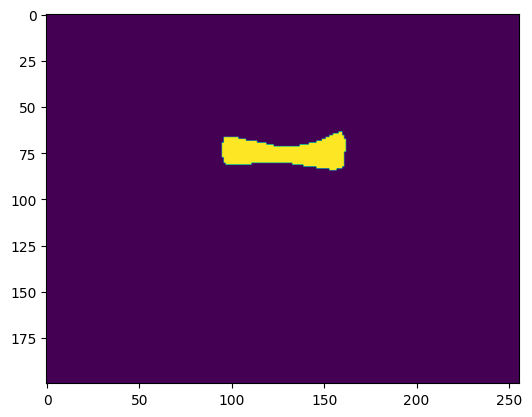

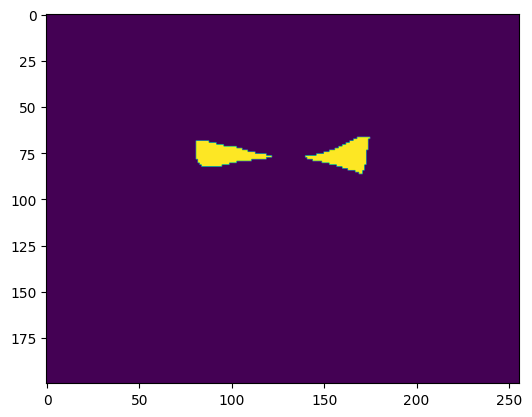

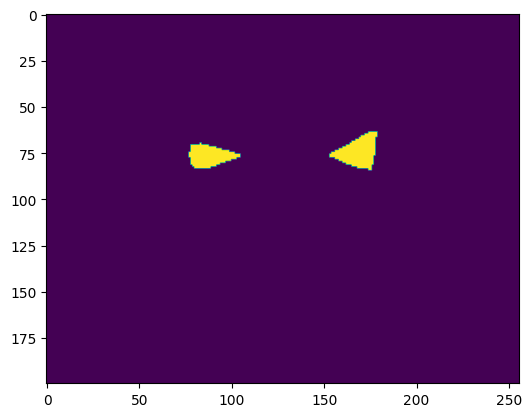

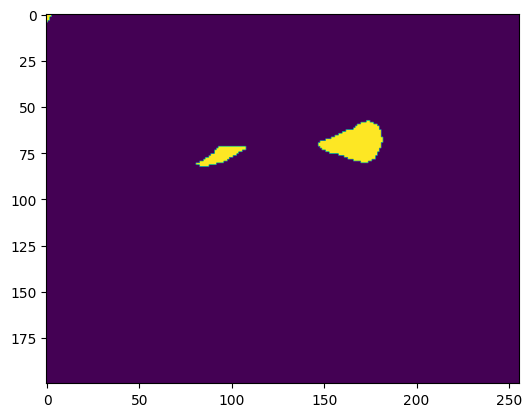

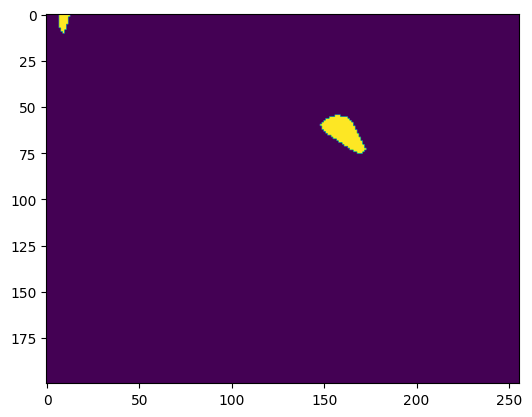

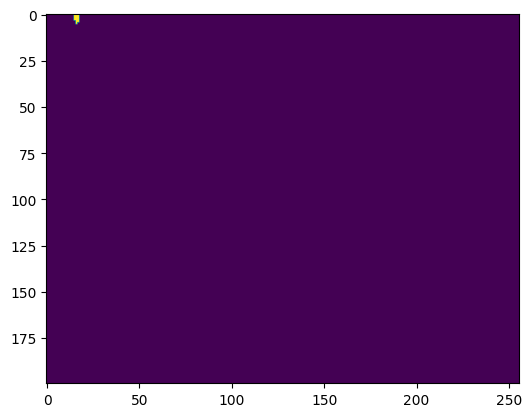

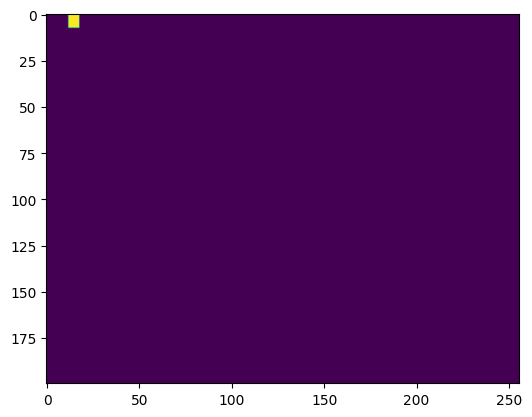

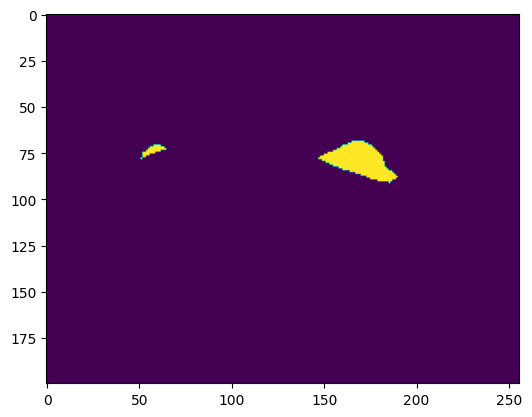

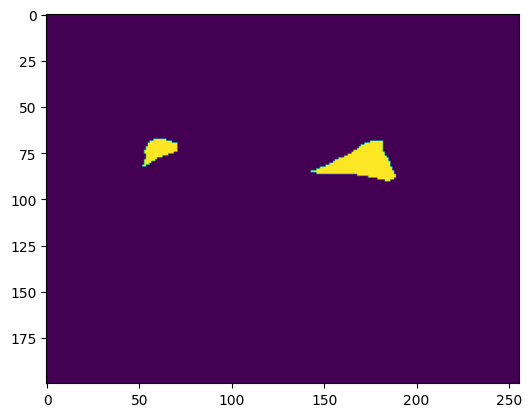

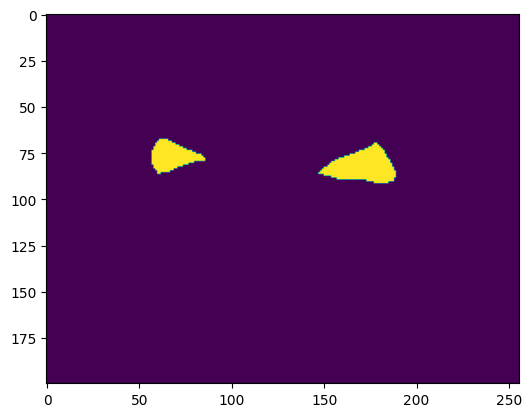

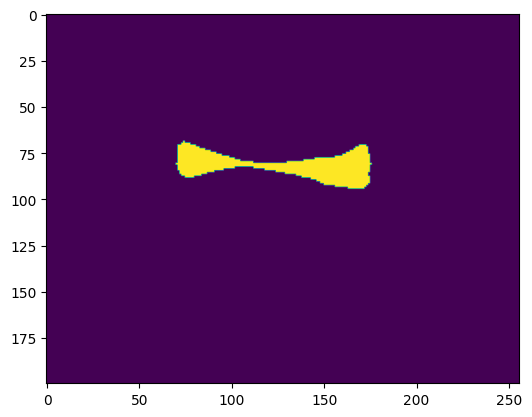

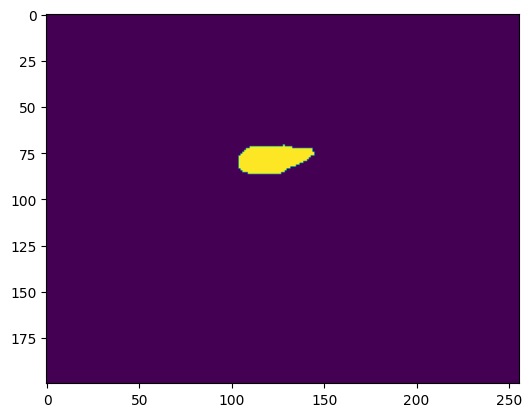

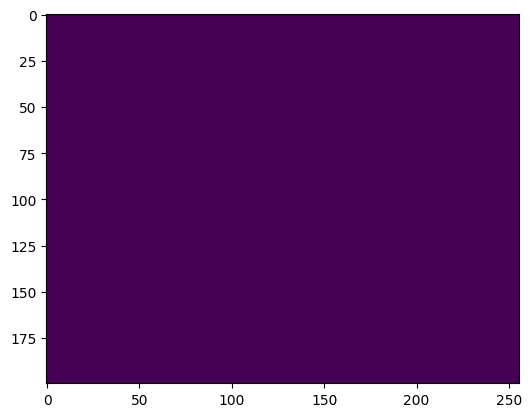

In [ ]:
im_path = os.path.join(DATA_DIR, 'test', test_paths[0] + '.im')
seg_path = os.path.join(DATA_DIR, 'ground-truth', test_paths[0] + '.npy')
with h5py.File(im_path,'r') as hf:
    image = np.array(hf['data'])
mask = np.load(seg_path)

# Get menisc masks from this

mask = mask[...,-1]

im = crop_im(image)
gt = crop_im(mask)


for i in range(16):
    plt.imshow(gt[...,10*i])
    plt.show()